<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/simpleNN_dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LAst amended: 2nd June, 2023
# Ref: https://www.kaggle.com/code/harnalashok/exercise-dropout-and-batch-normalization/edit
# Data Source: https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-01-21
# Spotify dataset

In [4]:
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
pathToFolder = "/gdrive/MyDrive/Colab_data_files/deeplearning"

In [8]:
path = Path(pathToFolder) / "spotify.csv.zip"

In [9]:
spotify = pd.read_csv(path)


In [10]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')

In [11]:
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [13]:
preprocessor = make_column_transformer(
                                        (StandardScaler(), features_num),
                                        (OneHotEncoder(), features_cat),
                                        )

In [16]:
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [15]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [17]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [18]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(a128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


<Axes: >

Minimum Validation Loss: 0.1992


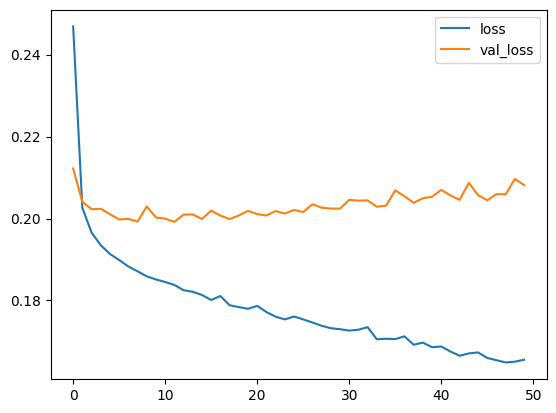

In [19]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [21]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


<Axes: >

Minimum Validation Loss: 0.1947


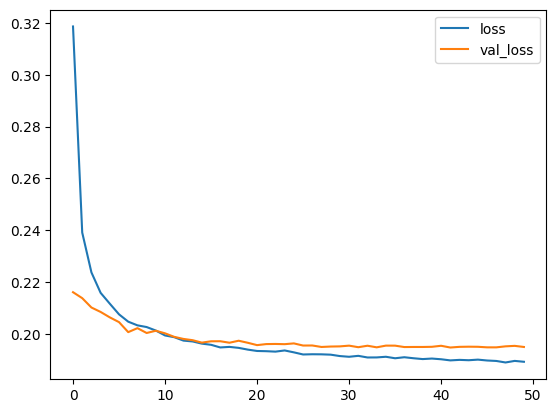

In [22]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))